In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

In [4]:
train_dataset = FashionMNIST("./data", train=True, download=True, transform=transforms.ToTensor())
test_dataset = FashionMNIST("./data", train=False, download=True, transform=transforms.ToTensor())

In [5]:
train_ratio = 0.9
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size

train_size, val_size

(54000, 6000)

In [6]:
batch_size = 512

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Train size: ", len(train_subset))
print("Validation size: ", len(val_loader))
print("Test size: ", len(test_loader))

Train size:  54000
Validation size:  12
Test size:  20


In [7]:
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_loss_lst, train_acc_lst = [], []
    val_loss_lst, val_acc_lst = [], []

    for epoch in range(epochs):
        train_loss, train_acc = 0.0, 0.0
        # Training phase
        model.train()
        
        # Training data in mini-batches
        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device) # Move data to the device (GPU/CPU)
            
            optimizer.zero_grad() # Clear previous gradients
            outputs = model(X_train) # Forward pass: compute model outputs
            loss = criterion(outputs, y_train) # Compute loss between outputs and ground truth
            loss.backward() # Backward pass: compute gradients
            optimizer.step() # Update model parameters using the optimizer
            
            train_loss += loss.item() # Accumulate total training loss
            train_acc += (torch.argmax(outputs, dim=1) == y_train).sum().item() / len(y_train)  # Compute accuracy
        
        # Average the losses and accuracy over the entire training set
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        # Store the training loss and accuracy for this epoch
        train_loss_lst.append(train_loss)
        train_acc_lst.append(train_acc)
        
        # Validation phase
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_loss_lst.append(val_loss)
        val_acc_lst.append(val_acc)
        
        print(
            f"Epoch {epoch+1}/{epochs} - "
            f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, "
            f"Validation loss: {val_loss:.4f}, Validation acc: {train_acc:.4f}"
        )
    return train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst


def evaluate(model, val_loader, criterion, device):
    val_loss, val_acc = 0.0, 0.0
    # Validation phase
    model.eval()
    with torch.no_grad(): # No need to compute gradients during validation
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val) # Get model predictions
            
            loss = criterion(outputs, y_val)  # Compute the loss
            val_loss += loss.item() # Accumulate total validation loss
            
            val_acc += (torch.argmax(outputs, dim=1) == y_val).sum().item() / len(y_val) # Compute accuracy

    # Compute average loss and accuracy for the validation set
    avg_loss = val_loss / len(val_loader)
    avg_acc = val_acc / len(val_loader)
    return avg_loss, avg_acc


def test(model, test_loader, criterion, device):
    test_loss, test_acc = 0.0, 0.0
    # Test phase
    model.eval()
    with torch.no_grad(): # No need to compute gradients during testing
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            outputs = model(X_test) # Get model predictions
            
            loss = criterion(outputs, y_test) # Compute the loss
            test_loss += loss.item() # Accumulate test loss
            
            test_acc += (torch.argmax(outputs, dim=1) == y_test).sum().item() / len(y_test) # Compute accuracy
        
    # Compute the average test loss and accuracy
    avg_loss = test_loss / len(test_loader)
    avg_acc = test_acc / len(test_loader)

    print("Evaluation on test set:")
    print(f"Accuracy: {avg_acc:.4f}")
    print(f"Loss: {avg_loss:.4f}")
    return avg_acc, avg_loss

In [8]:
def plot(train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst):
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    ax[0, 0].plot(train_loss_lst, color="green")
    ax[0, 0].set(xlabel="Epoch", ylabel="Loss")
    ax[0, 0].set_title("Training Loss")

    ax[0, 1].plot(val_loss_lst, color="orange")
    ax[0, 1].set(xlabel="Epoch", ylabel="Loss")
    ax[0, 1].set_title("Validation  Loss")

    ax[1, 0].plot(train_acc_lst, color="green")
    ax[1, 0].set(xlabel="Epoch", ylabel="Accuracy")
    ax[1, 0].set_title("Training Accuracy")

    ax[1, 1].plot(val_acc_lst, color="orange")
    ax[1, 1].set(xlabel="Epoch", ylabel="Accuracy")
    ax[1, 1].set_title("Validation Accuracy")

    plt.show()

## Original Vanishing Model

In [9]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
    
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)
        return out


input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [10]:
train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=100)

Epoch 1/100 - Train loss: 2.3073, Train acc: 0.0998, Validation loss: 2.3034, Validation acc: 0.0998
Epoch 2/100 - Train loss: 2.3028, Train acc: 0.0978, Validation loss: 2.3027, Validation acc: 0.0978
Epoch 3/100 - Train loss: 2.3028, Train acc: 0.0992, Validation loss: 2.3030, Validation acc: 0.0992
Epoch 4/100 - Train loss: 2.3027, Train acc: 0.1009, Validation loss: 2.3028, Validation acc: 0.1009
Epoch 5/100 - Train loss: 2.3028, Train acc: 0.0980, Validation loss: 2.3030, Validation acc: 0.0980
Epoch 6/100 - Train loss: 2.3028, Train acc: 0.0973, Validation loss: 2.3028, Validation acc: 0.0973
Epoch 7/100 - Train loss: 2.3028, Train acc: 0.1007, Validation loss: 2.3028, Validation acc: 0.1007
Epoch 8/100 - Train loss: 2.3027, Train acc: 0.1013, Validation loss: 2.3027, Validation acc: 0.1013
Epoch 9/100 - Train loss: 2.3028, Train acc: 0.0997, Validation loss: 2.3034, Validation acc: 0.0997
Epoch 10/100 - Train loss: 2.3028, Train acc: 0.0996, Validation loss: 2.3029, Validation a

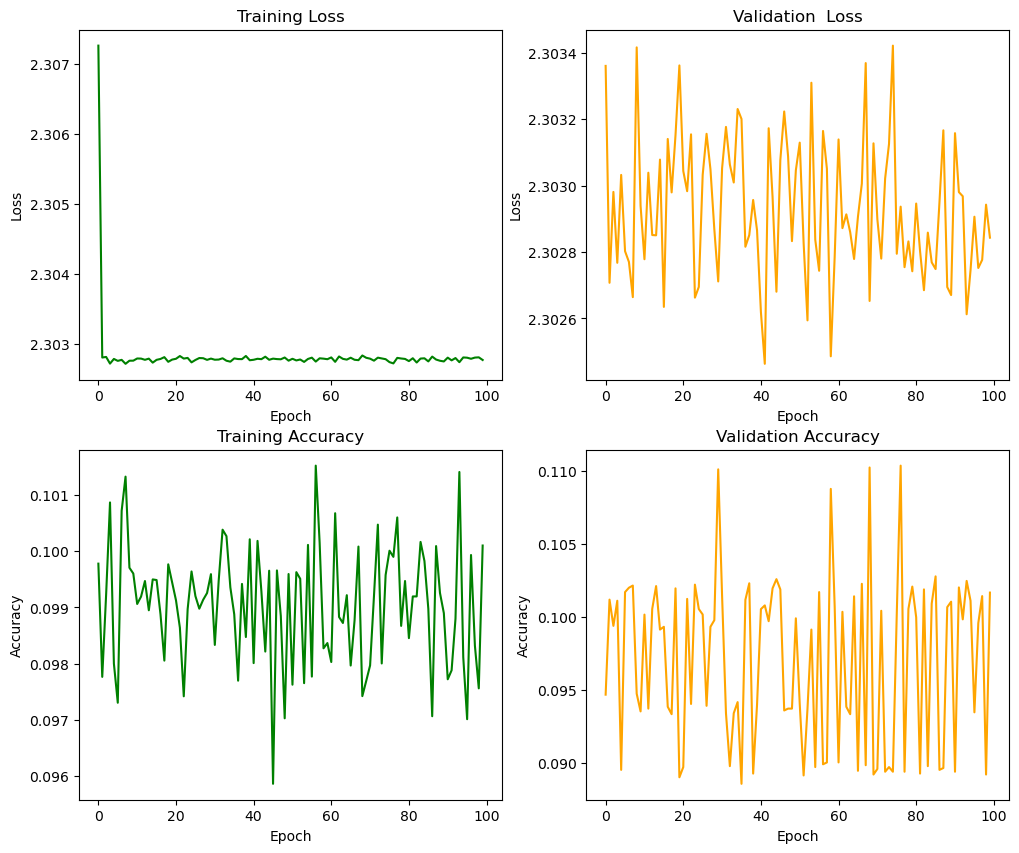

In [11]:
plot(train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst)

In [12]:
test_acc, test_loss = test(model, test_loader, criterion, device)

Evaluation on test set:
Accuracy: 0.0995
Loss: 2.3027


## 1. Weight Increasing

Kỹ thuật này tập trung vào việc khởi tạo trọng số ban đầu với các
giá trị lớn hơn nhằm tăng giá trị gradient trong các bước lan truyền ngược. Điều này giúp
hạn chế việc gradient bị triệt tiêu qua các lớp, đặc biệt khi sử dụng các hàm kích hoạt dễ
bão hòa như Sigmoid. Tại đây, chúng ta triển khai ý tưởng này bằng cách khởi tạo trọng
số với phân phối chuẩn (normal distribution) và sử dụng hai thiết lập khác nhau để đánh
giá tác động: một với độ lệch chuẩn (std) là 1.0 và một với std là 10.0.

### a. std = 1.0

In [13]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=1.0)
                nn.init.constant_(module.bias, 0.0)
        
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)
        return out


input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [14]:
train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=100)

Epoch 1/100 - Train loss: 3.7414, Train acc: 0.1852, Validation loss: 2.0912, Validation acc: 0.1852
Epoch 2/100 - Train loss: 1.9048, Train acc: 0.3511, Validation loss: 1.7725, Validation acc: 0.3511
Epoch 3/100 - Train loss: 1.6739, Train acc: 0.4252, Validation loss: 1.6124, Validation acc: 0.4252
Epoch 4/100 - Train loss: 1.5428, Train acc: 0.4668, Validation loss: 1.5095, Validation acc: 0.4668
Epoch 5/100 - Train loss: 1.4535, Train acc: 0.4962, Validation loss: 1.4368, Validation acc: 0.4962
Epoch 6/100 - Train loss: 1.3865, Train acc: 0.5175, Validation loss: 1.3752, Validation acc: 0.5175
Epoch 7/100 - Train loss: 1.3322, Train acc: 0.5344, Validation loss: 1.3281, Validation acc: 0.5344
Epoch 8/100 - Train loss: 1.2865, Train acc: 0.5487, Validation loss: 1.2855, Validation acc: 0.5487
Epoch 9/100 - Train loss: 1.2474, Train acc: 0.5608, Validation loss: 1.2524, Validation acc: 0.5608
Epoch 10/100 - Train loss: 1.2133, Train acc: 0.5718, Validation loss: 1.2209, Validation a

Epoch 14/100 - Train loss: 1.1081, Train acc: 0.6052, Validation loss: 1.1316, Validation acc: 0.6052
Epoch 15/100 - Train loss: 1.0883, Train acc: 0.6111, Validation loss: 1.1123, Validation acc: 0.6111
Epoch 16/100 - Train loss: 1.0691, Train acc: 0.6164, Validation loss: 1.0960, Validation acc: 0.6164
Epoch 17/100 - Train loss: 1.0519, Train acc: 0.6207, Validation loss: 1.0818, Validation acc: 0.6207
Epoch 18/100 - Train loss: 1.0364, Train acc: 0.6260, Validation loss: 1.0677, Validation acc: 0.6260
Epoch 19/100 - Train loss: 1.0223, Train acc: 0.6310, Validation loss: 1.0506, Validation acc: 0.6310
Epoch 20/100 - Train loss: 1.0093, Train acc: 0.6355, Validation loss: 1.0406, Validation acc: 0.6355
Epoch 21/100 - Train loss: 0.9971, Train acc: 0.6393, Validation loss: 1.0301, Validation acc: 0.6393
Epoch 22/100 - Train loss: 0.9859, Train acc: 0.6432, Validation loss: 1.0209, Validation acc: 0.6432
Epoch 23/100 - Train loss: 0.9750, Train acc: 0.6462, Validation loss: 1.0095, Val

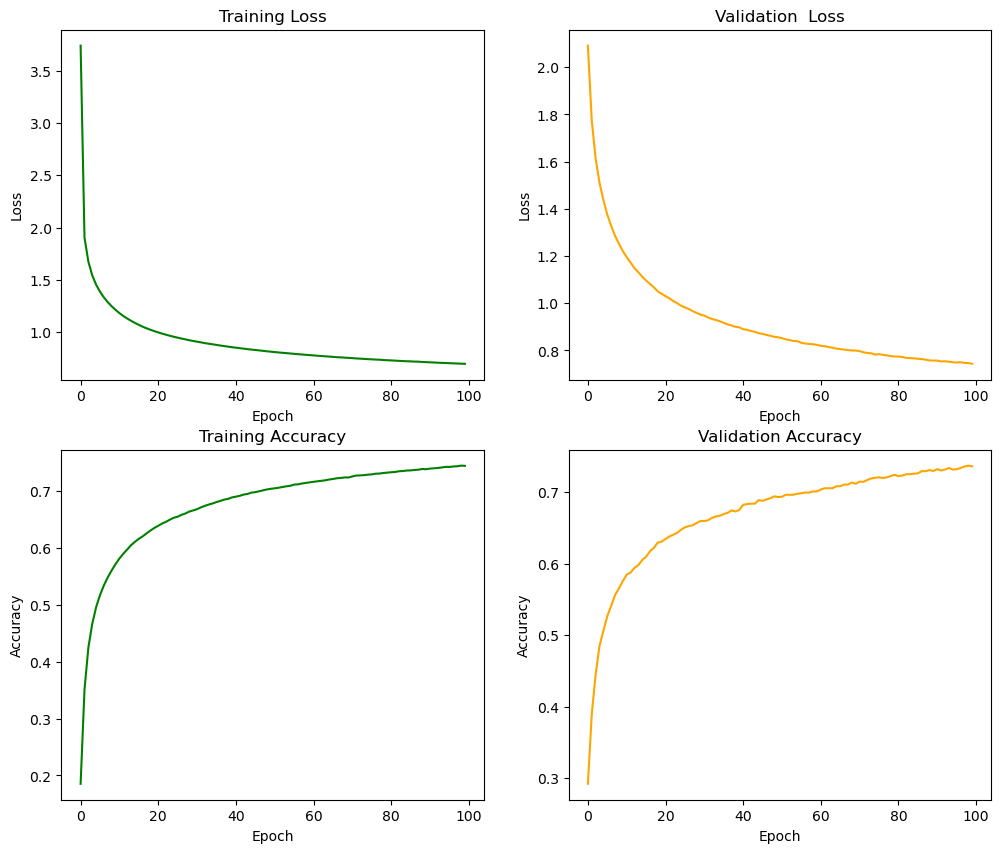

In [15]:
plot(train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst)

In [16]:
test_acc, test_loss = test(model, test_loader, criterion, device)

Evaluation on test set:
Accuracy: 0.7311
Loss: 0.7354


### b. std = 10.0

In [17]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=10.0)
                nn.init.constant_(module.bias, 0.0)
        
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)
        return out


input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [18]:
train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=100)

Epoch 1/100 - Train loss: 93.9854, Train acc: 0.0969, Validation loss: 81.1799, Validation acc: 0.0969
Epoch 2/100 - Train loss: 74.9593, Train acc: 0.0993, Validation loss: 65.4137, Validation acc: 0.0993
Epoch 3/100 - Train loss: 61.8729, Train acc: 0.0991, Validation loss: 54.7931, Validation acc: 0.0991
Epoch 4/100 - Train loss: 49.8953, Train acc: 0.1049, Validation loss: 48.6837, Validation acc: 0.1049
Epoch 5/100 - Train loss: 47.3227, Train acc: 0.1068, Validation loss: 46.8609, Validation acc: 0.1068
Epoch 6/100 - Train loss: 45.3315, Train acc: 0.1023, Validation loss: 43.2654, Validation acc: 0.1023
Epoch 7/100 - Train loss: 45.0093, Train acc: 0.1022, Validation loss: 51.1553, Validation acc: 0.1022
Epoch 8/100 - Train loss: 40.2431, Train acc: 0.1016, Validation loss: 37.2201, Validation acc: 0.1016
Epoch 9/100 - Train loss: 37.3675, Train acc: 0.1057, Validation loss: 36.6911, Validation acc: 0.1057
Epoch 10/100 - Train loss: 33.6902, Train acc: 0.0978, Validation loss: 3

Epoch 24/100 - Train loss: 4.3017, Train acc: 0.1354, Validation loss: 4.0586, Validation acc: 0.1354
Epoch 25/100 - Train loss: 3.9489, Train acc: 0.1533, Validation loss: 3.6971, Validation acc: 0.1533
Epoch 26/100 - Train loss: 3.5106, Train acc: 0.1415, Validation loss: 3.3915, Validation acc: 0.1415
Epoch 27/100 - Train loss: 3.2850, Train acc: 0.1289, Validation loss: 3.2509, Validation acc: 0.1289
Epoch 28/100 - Train loss: 3.1916, Train acc: 0.1337, Validation loss: 3.2036, Validation acc: 0.1337
Epoch 29/100 - Train loss: 3.1190, Train acc: 0.1191, Validation loss: 3.0802, Validation acc: 0.1191
Epoch 30/100 - Train loss: 3.0113, Train acc: 0.1128, Validation loss: 2.9580, Validation acc: 0.1128
Epoch 31/100 - Train loss: 2.8926, Train acc: 0.1100, Validation loss: 2.8703, Validation acc: 0.1100
Epoch 32/100 - Train loss: 2.8707, Train acc: 0.1060, Validation loss: 2.8016, Validation acc: 0.1060
Epoch 33/100 - Train loss: 2.7992, Train acc: 0.1096, Validation loss: 2.7626, Val

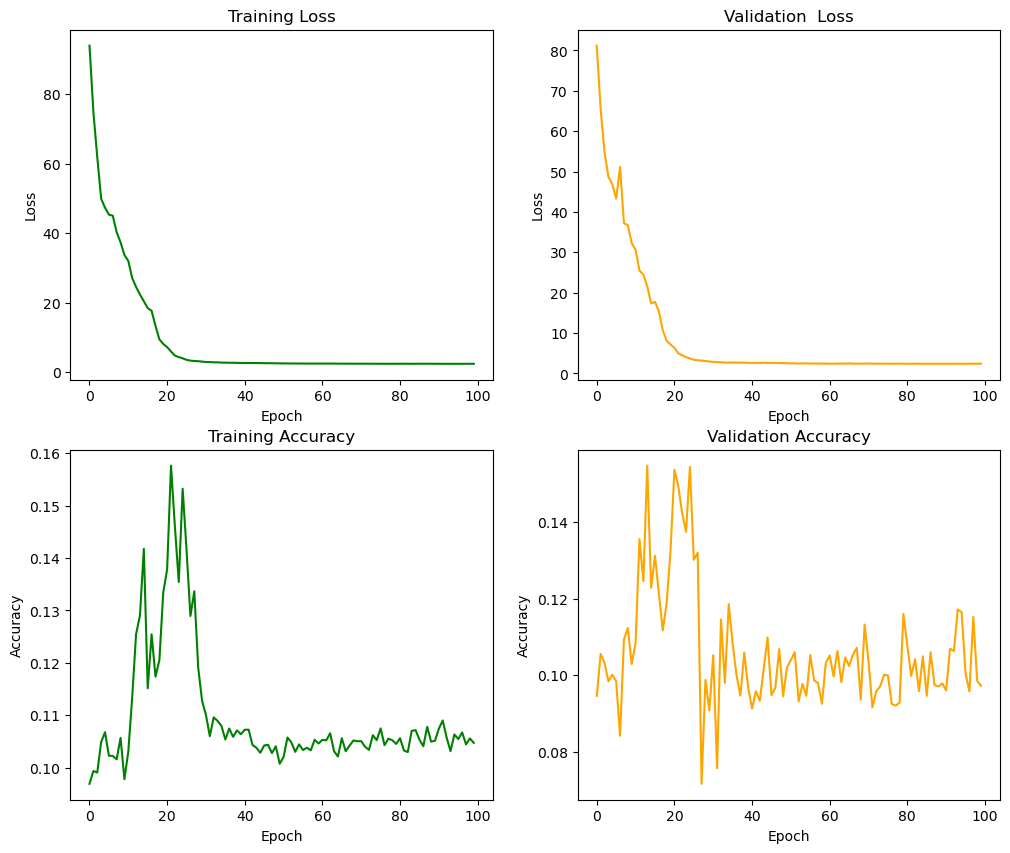

In [19]:
plot(train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst)

In [20]:
test_acc, test_loss = test(model, test_loader, criterion, device)

Evaluation on test set:
Accuracy: 0.1054
Loss: 2.3978


## 2. Better Activation

Kỹ thuật này liên quan đến việc thay đổi hàm kích hoạt trong mạng
thành các hàm tiên tiến hơn. Những hàm này có khả năng hạn chế hiện tượng bão hòa,
giúp gradient duy trì giá trị hợp lý qua các lớp mạng. Tại đây, chúng ta triển khai ý tưởng
này bằng cách thay thế tất cả các hàm Sigmoid trong mạng baseline bằng ReLU. Ngoài
ra, trọng số của các lớp Linear cũng được khởi tạo với độ lệch chuẩn nhỏ hơn (std = 0.05)
để phù hợp với tính chất của ReLU.


In [9]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.05)
                nn.init.constant_(m.bias, 0.0)
    
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        x = nn.ReLU()(x)
        x = self.layer4(x)
        x = nn.ReLU()(x)
        x = self.layer5(x)
        x = nn.ReLU()(x)
        x = self.layer6(x)
        x = nn.ReLU()(x)
        x = self.layer7(x)
        x = nn.ReLU()(x)
        out = self.output(x)
        return out
    
input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [10]:
train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=100)

Epoch 1/100 - Train loss: 2.3024, Train acc: 0.1328, Validation loss: 2.3024, Validation acc: 0.1328
Epoch 2/100 - Train loss: 2.3023, Train acc: 0.1523, Validation loss: 2.3023, Validation acc: 0.1523
Epoch 3/100 - Train loss: 2.3022, Train acc: 0.1354, Validation loss: 2.3022, Validation acc: 0.1354
Epoch 4/100 - Train loss: 2.3020, Train acc: 0.1271, Validation loss: 2.3021, Validation acc: 0.1271
Epoch 5/100 - Train loss: 2.3019, Train acc: 0.1045, Validation loss: 2.3020, Validation acc: 0.1045
Epoch 6/100 - Train loss: 2.3018, Train acc: 0.1110, Validation loss: 2.3020, Validation acc: 0.1110
Epoch 7/100 - Train loss: 2.3017, Train acc: 0.1307, Validation loss: 2.3019, Validation acc: 0.1307
Epoch 8/100 - Train loss: 2.3016, Train acc: 0.1122, Validation loss: 2.3018, Validation acc: 0.1122
Epoch 9/100 - Train loss: 2.3015, Train acc: 0.1027, Validation loss: 2.3017, Validation acc: 0.1027
Epoch 10/100 - Train loss: 2.3014, Train acc: 0.1639, Validation loss: 2.3016, Validation a

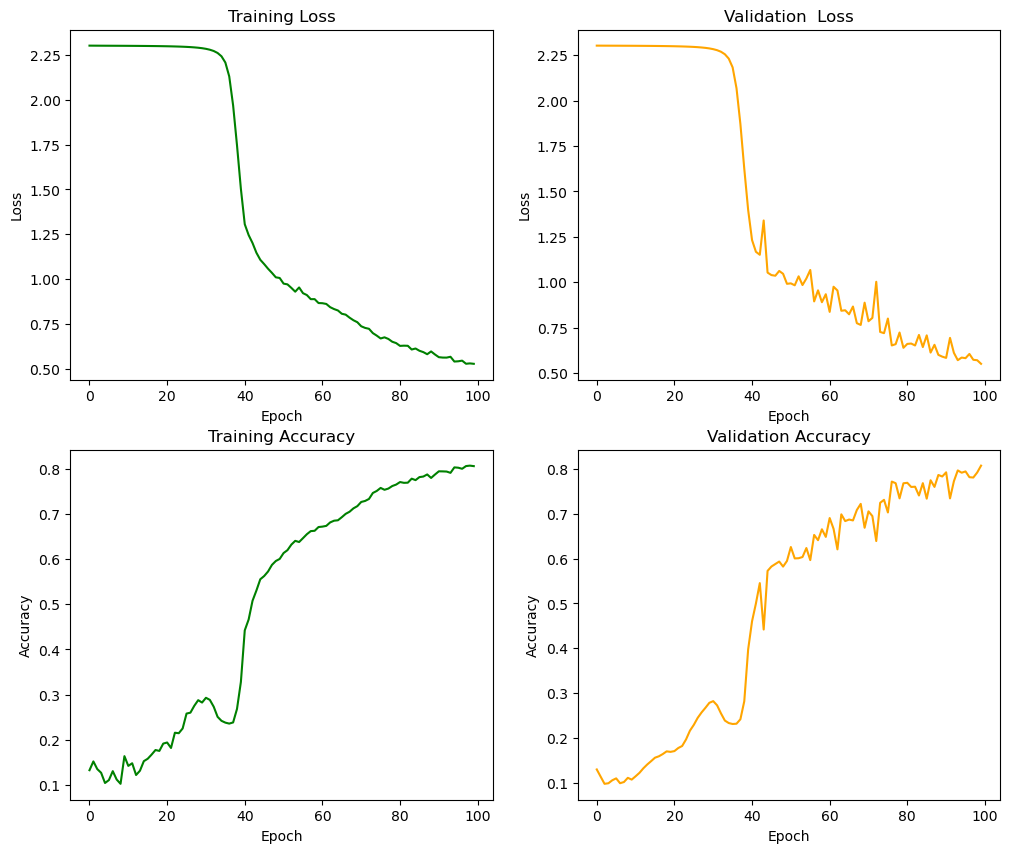

In [11]:
plot(train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst)

In [12]:
test_acc, test_loss = test(model, test_loader, criterion, device)

Evaluation on test set:
Accuracy: 0.8003
Loss: 0.5595


## 3. Better Optimizer:

Lựa chọn thuật toán tối ưu phù hợp có thể giúp cải thiện vấn đề
Vanishing Gradient bằng cách điều chỉnh gradient linh hoạt hơn trong quá trình lan truyền
ngược. Tại đây, chúng ta thay SGD bằng Adam, một thuật toán hiện đại với khả năng tự
động điều chỉnh tốc độ học, để kiểm tra hiệu quả cải thiện của nó trong việc giảm thiểu
Vanishing Gradient.

In [13]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.05)
                nn.init.constant_(m.bias, 0.0)
    
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)
        return out
    
input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-3

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [14]:
train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=100)

Epoch 1/100 - Train loss: 2.2253, Train acc: 0.1331, Validation loss: 1.7465, Validation acc: 0.1331
Epoch 2/100 - Train loss: 1.7039, Train acc: 0.1985, Validation loss: 1.6968, Validation acc: 0.1985
Epoch 3/100 - Train loss: 1.6858, Train acc: 0.1983, Validation loss: 1.6886, Validation acc: 0.1983
Epoch 4/100 - Train loss: 1.6829, Train acc: 0.2007, Validation loss: 1.6869, Validation acc: 0.2007
Epoch 5/100 - Train loss: 1.6707, Train acc: 0.2061, Validation loss: 1.6396, Validation acc: 0.2061
Epoch 6/100 - Train loss: 1.4627, Train acc: 0.3405, Validation loss: 1.2751, Validation acc: 0.3405
Epoch 7/100 - Train loss: 1.0561, Train acc: 0.5464, Validation loss: 0.9515, Validation acc: 0.5464
Epoch 8/100 - Train loss: 0.8761, Train acc: 0.6373, Validation loss: 0.8236, Validation acc: 0.6373
Epoch 9/100 - Train loss: 0.7591, Train acc: 0.7113, Validation loss: 0.7438, Validation acc: 0.7113
Epoch 10/100 - Train loss: 0.6920, Train acc: 0.7299, Validation loss: 0.6936, Validation a

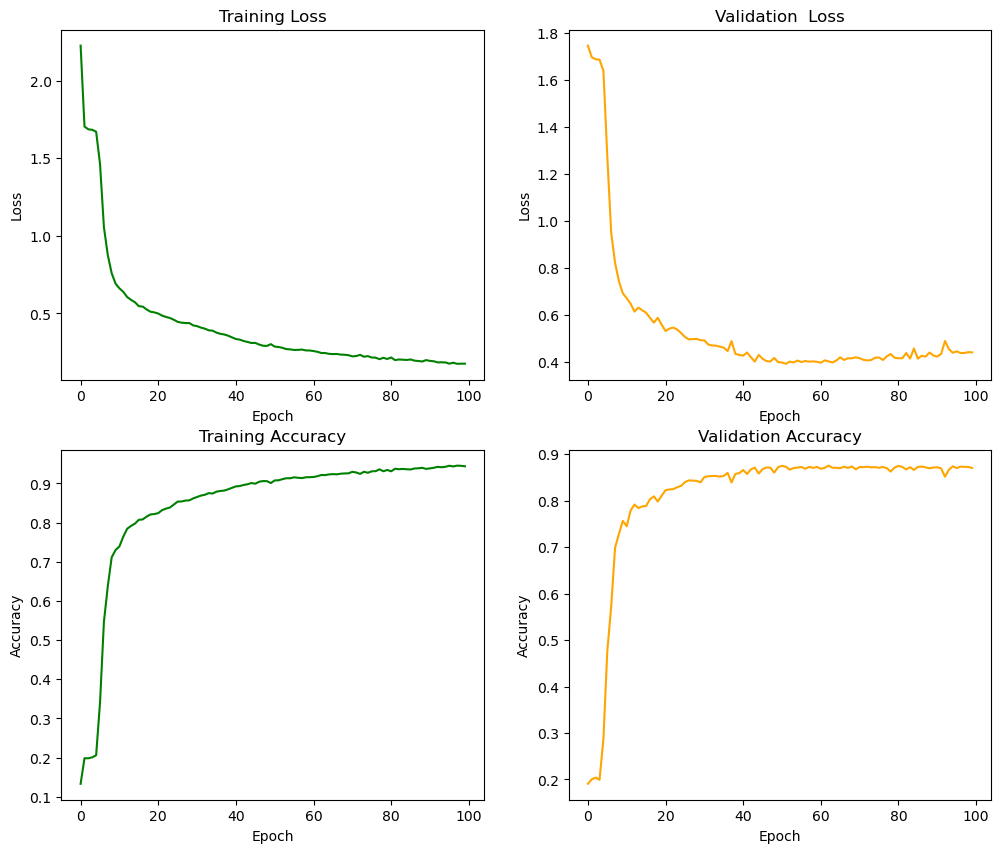

In [15]:
plot(train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst)

In [16]:
test_acc, test_loss = test(model, test_loader, criterion, device)

Evaluation on test set:
Accuracy: 0.8670
Loss: 0.4610


## 4. Normalize Inside Network

Batch Normalization là một kỹ thuật phổ biến để giữ các
đầu vào của từng lớp mạng trong khoảng ổn định, giúp gradient không bị triệt tiêu hoặc
phóng đại. Kỹ thuật này cũng góp phần tăng tốc độ hội tụ và cải thiện khả năng tổng quát
hóa của mô hình

### a. Normalize Inside Network

 Batch Normalization là một kỹ thuật phổ biến giúp
chuẩn hóa đầu ra của từng lớp, giữ giá trị trong khoảng ổn định và cải thiện tốc độ hội
tụ. Trong phần này, chúng ta thêm nn.BatchNorm1d() sau mỗi lớp Linear trong mạng
baseline. Batch Normalization giúp giảm thiểu nguy cơ bão hòa và duy trì gradient
ổn định qua các lớp.


In [26]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.hidden_dims = hidden_dims
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.bn1 = nn.BatchNorm1d(hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.bn2 = nn.BatchNorm1d(hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.bn3 = nn.BatchNorm1d(hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.bn4 = nn.BatchNorm1d(hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.bn5 = nn.BatchNorm1d(hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.bn6 = nn.BatchNorm1d(hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.bn7 = nn.BatchNorm1d(hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.05)
                nn.init.constant_(m.bias, 0.0)
    
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = self.bn1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = self.bn2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = self.bn3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = self.bn4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = self.bn5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = self.bn6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = self.bn7(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)
        return out


input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-3

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [27]:
train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=100)

Epoch 1/100 - Train loss: 2.2360, Train acc: 0.1944, Validation loss: 2.1721, Validation acc: 0.1944
Epoch 2/100 - Train loss: 2.1267, Train acc: 0.3600, Validation loss: 2.0803, Validation acc: 0.3600
Epoch 3/100 - Train loss: 2.0437, Train acc: 0.5241, Validation loss: 2.0054, Validation acc: 0.5241
Epoch 4/100 - Train loss: 1.9745, Train acc: 0.6021, Validation loss: 1.9421, Validation acc: 0.6021
Epoch 5/100 - Train loss: 1.9141, Train acc: 0.6310, Validation loss: 1.8861, Validation acc: 0.6310
Epoch 6/100 - Train loss: 1.8596, Train acc: 0.6437, Validation loss: 1.8351, Validation acc: 0.6437
Epoch 7/100 - Train loss: 1.8100, Train acc: 0.6528, Validation loss: 1.7866, Validation acc: 0.6528
Epoch 8/100 - Train loss: 1.7633, Train acc: 0.6606, Validation loss: 1.7424, Validation acc: 0.6606
Epoch 9/100 - Train loss: 1.7205, Train acc: 0.6652, Validation loss: 1.7013, Validation acc: 0.6652
Epoch 10/100 - Train loss: 1.6807, Train acc: 0.6714, Validation loss: 1.6651, Validation a

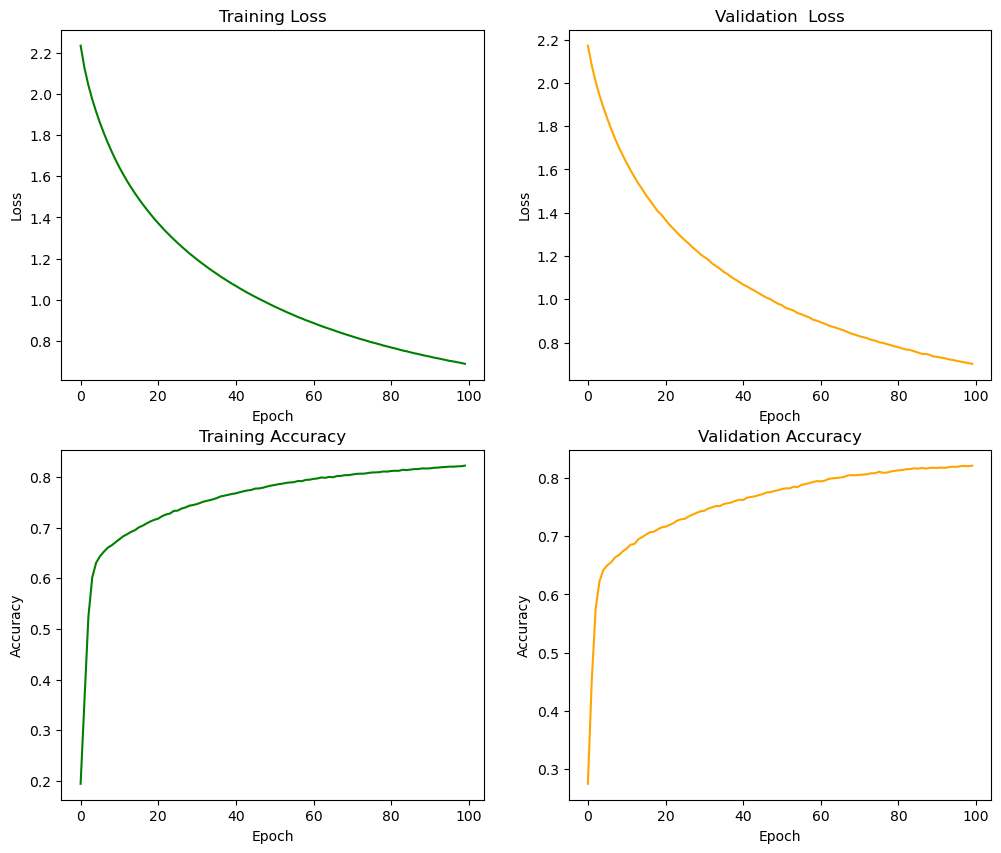

In [28]:
plot(train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst)

In [29]:
test_acc, test_loss = test(model, test_loader, criterion, device)

Evaluation on test set:
Accuracy: 0.8123
Loss: 0.7059


### b. Customized Normalization Layer

In [30]:
class CustomNormalization(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean) / std

In [39]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.hidden_dims = hidden_dims
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.norm1 = CustomNormalization()
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.norm2 = CustomNormalization()
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.norm3 = CustomNormalization()
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.norm4 = CustomNormalization()
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.norm5 = CustomNormalization()
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.norm6 = CustomNormalization()
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.norm7 = CustomNormalization()
        self.output = nn.Linear(hidden_dims, output_dims)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.05)
                nn.init.constant_(m.bias, 0.0)
    
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = self.norm1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = self.norm2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = self.norm3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = self.norm4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = self.norm5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = self.norm6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = self.norm7(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)
        return out


input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-3

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [40]:
train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=100)

Epoch 1/100 - Train loss: 2.3236, Train acc: 0.0990, Validation loss: 2.3109, Validation acc: 0.0990
Epoch 2/100 - Train loss: 2.3106, Train acc: 0.0990, Validation loss: 2.3051, Validation acc: 0.0990
Epoch 3/100 - Train loss: 2.3057, Train acc: 0.0988, Validation loss: 2.3033, Validation acc: 0.0988
Epoch 4/100 - Train loss: 2.3038, Train acc: 0.0989, Validation loss: 2.3027, Validation acc: 0.0989
Epoch 5/100 - Train loss: 2.3031, Train acc: 0.0976, Validation loss: 2.3025, Validation acc: 0.0976
Epoch 6/100 - Train loss: 2.3028, Train acc: 0.0944, Validation loss: 2.3026, Validation acc: 0.0944
Epoch 7/100 - Train loss: 2.3027, Train acc: 0.1002, Validation loss: 2.3027, Validation acc: 0.1002
Epoch 8/100 - Train loss: 2.3027, Train acc: 0.1007, Validation loss: 2.3028, Validation acc: 0.1007
Epoch 9/100 - Train loss: 2.3027, Train acc: 0.0990, Validation loss: 2.3029, Validation acc: 0.0990
Epoch 10/100 - Train loss: 2.3026, Train acc: 0.0986, Validation loss: 2.3029, Validation a

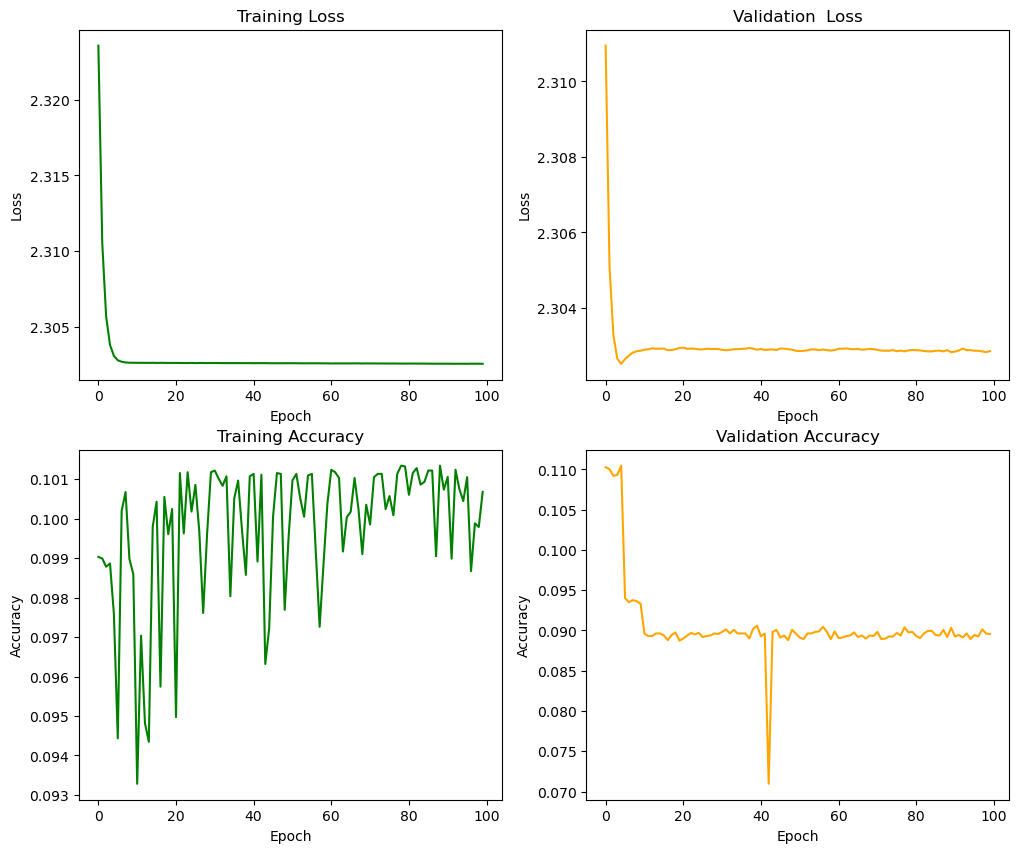

In [41]:
plot(train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst)

In [42]:
test_acc, test_loss = test(model, test_loader, criterion, device)

Evaluation on test set:
Accuracy: 0.0997
Loss: 2.3026


## 5. Skip Connection

Được giới thiệu trong kiến trúc của mạng ResNet, giúp gradient có
thể lan truyền trực tiếp qua các lớp mà không bị triệt tiêu. Điều này không chỉ cải thiện
khả năng hội tụ mà còn giữ được thông tin từ các tầng trước đó. Tại đây, chúng ta triển
khai skip connections bằng cách cộng đầu ra của các lớp trước (skip connections) với các
lớp tiếp theo tại một số điểm trong mạng.

In [43]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)
    
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        skip = x
        
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = skip + x
        
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        skip = x
        
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        x = skip + x
        
        out = self.output(x)
        return out
        
input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-3

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [44]:
train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=100)

Epoch 1/100 - Train loss: 2.3349, Train acc: 0.0999, Validation loss: 2.3063, Validation acc: 0.0999
Epoch 2/100 - Train loss: 2.3035, Train acc: 0.0990, Validation loss: 2.3014, Validation acc: 0.0990
Epoch 3/100 - Train loss: 2.3014, Train acc: 0.0930, Validation loss: 2.3012, Validation acc: 0.0930
Epoch 4/100 - Train loss: 2.3010, Train acc: 0.1134, Validation loss: 2.3010, Validation acc: 0.1134
Epoch 5/100 - Train loss: 2.3008, Train acc: 0.1272, Validation loss: 2.3009, Validation acc: 0.1272
Epoch 6/100 - Train loss: 2.3005, Train acc: 0.1357, Validation loss: 2.3006, Validation acc: 0.1357
Epoch 7/100 - Train loss: 2.3003, Train acc: 0.1295, Validation loss: 2.3003, Validation acc: 0.1295
Epoch 8/100 - Train loss: 2.3000, Train acc: 0.1513, Validation loss: 2.3002, Validation acc: 0.1513
Epoch 9/100 - Train loss: 2.2998, Train acc: 0.1480, Validation loss: 2.3001, Validation acc: 0.1480
Epoch 10/100 - Train loss: 2.2995, Train acc: 0.1657, Validation loss: 2.2998, Validation a

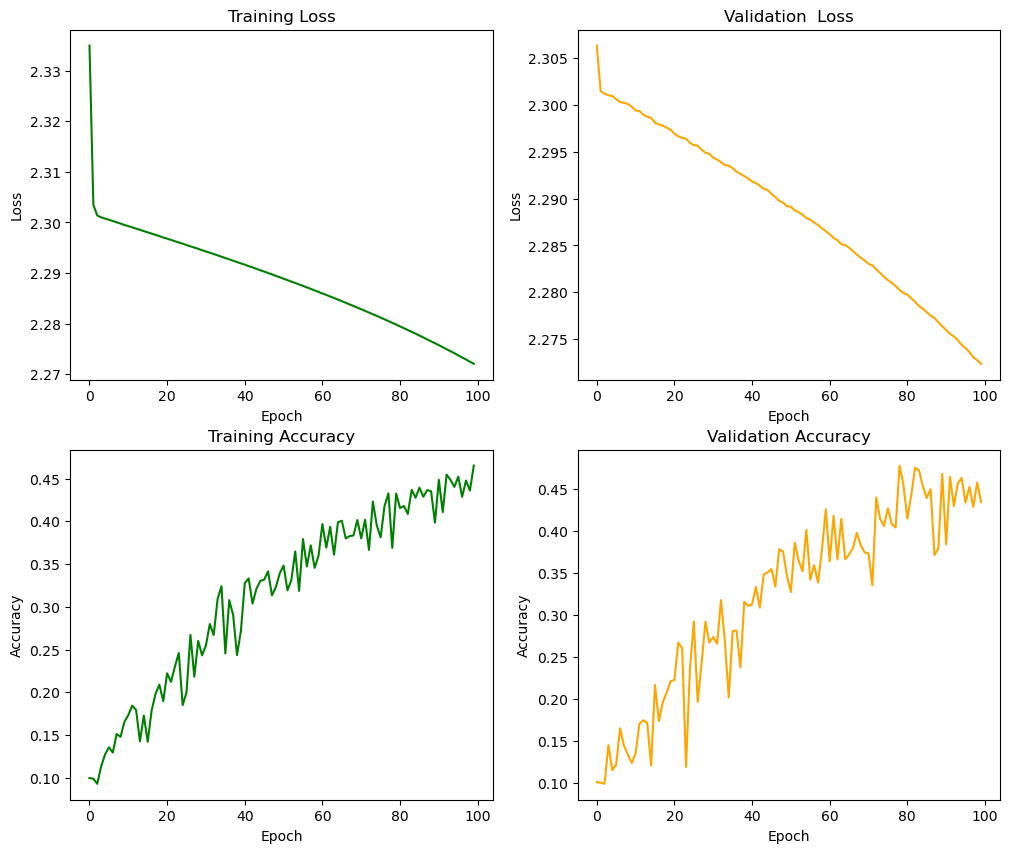

In [45]:
plot(train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst)

In [46]:
test_acc, test_loss = test(model, test_loader, criterion, device)

Evaluation on test set:
Accuracy: 0.4448
Loss: 2.2719


## 6. Train Layers Separately (fine-tuning)

Trong các mạng rất sâu, việc huấn luyện toàn
bộ các lớp có thể dẫn đến hiệu suất thấp do vấn đề Vanishing Gradient. Bằng cách chỉ
huấn luyện một số lớp cụ thể, mô hình có thể tập trung vào việc học các đặc trưng quan
trọng hơn mà không bị ảnh hưởng bởi các lớp sâu hơn. Kỹ thuật này được triển khai bằng
cách xây dựng các mô hình nhỏ hơn tương ứng với từng số lượng lớp cần huấn luyện, sau
đó tăng dần các lớp được tham gia huấn luyện.


In [48]:
class MLP_1_layer(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_1_layer, self).__init__()
        self.layer1 = nn.Linear(input_dims, output_dims)
        
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)
                
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        return x


class MLP_2_layer(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_2_layer, self).__init__()
        self.layer1 = nn.Linear(input_dims, output_dims)
        self.layer2 = nn.Linear(output_dims, output_dims)
    
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)
    
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        return x

In [49]:
first = MLP_2_layer(input_dims=784, output_dims=128)
second = MLP_2_layer(input_dims=128, output_dims=128)
third = MLP_2_layer(input_dims=128, output_dims=128)
fourth = MLP_1_layer(input_dims=128, output_dims=128)

lr = 1e-2
criterion = nn.CrossEntropyLoss()

Lần lượt huấn luyện từng mô hình con. Sau khi một mô hình con đã huấn luyện xong,
ta đóng băng trọng số đã train của mô hình, kết nối mô hình con tiếp theo và tiếp tục quá trình
training.

In [50]:
model = nn.Sequential(
    first,
    nn.Linear(128, 10)
).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)

train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=100)

Epoch 1/100 - Train loss: 2.3091, Train acc: 0.1109, Validation loss: 2.2988, Validation acc: 0.1109
Epoch 2/100 - Train loss: 2.2973, Train acc: 0.1578, Validation loss: 2.2959, Validation acc: 0.1578
Epoch 3/100 - Train loss: 2.2946, Train acc: 0.2163, Validation loss: 2.2937, Validation acc: 0.2163
Epoch 4/100 - Train loss: 2.2920, Train acc: 0.2251, Validation loss: 2.2906, Validation acc: 0.2251
Epoch 5/100 - Train loss: 2.2889, Train acc: 0.2217, Validation loss: 2.2875, Validation acc: 0.2217
Epoch 6/100 - Train loss: 2.2859, Train acc: 0.2993, Validation loss: 2.2847, Validation acc: 0.2993
Epoch 7/100 - Train loss: 2.2827, Train acc: 0.3339, Validation loss: 2.2813, Validation acc: 0.3339
Epoch 8/100 - Train loss: 2.2791, Train acc: 0.3599, Validation loss: 2.2777, Validation acc: 0.3599
Epoch 9/100 - Train loss: 2.2752, Train acc: 0.3645, Validation loss: 2.2731, Validation acc: 0.3645
Epoch 10/100 - Train loss: 2.2709, Train acc: 0.4125, Validation loss: 2.2691, Validation a

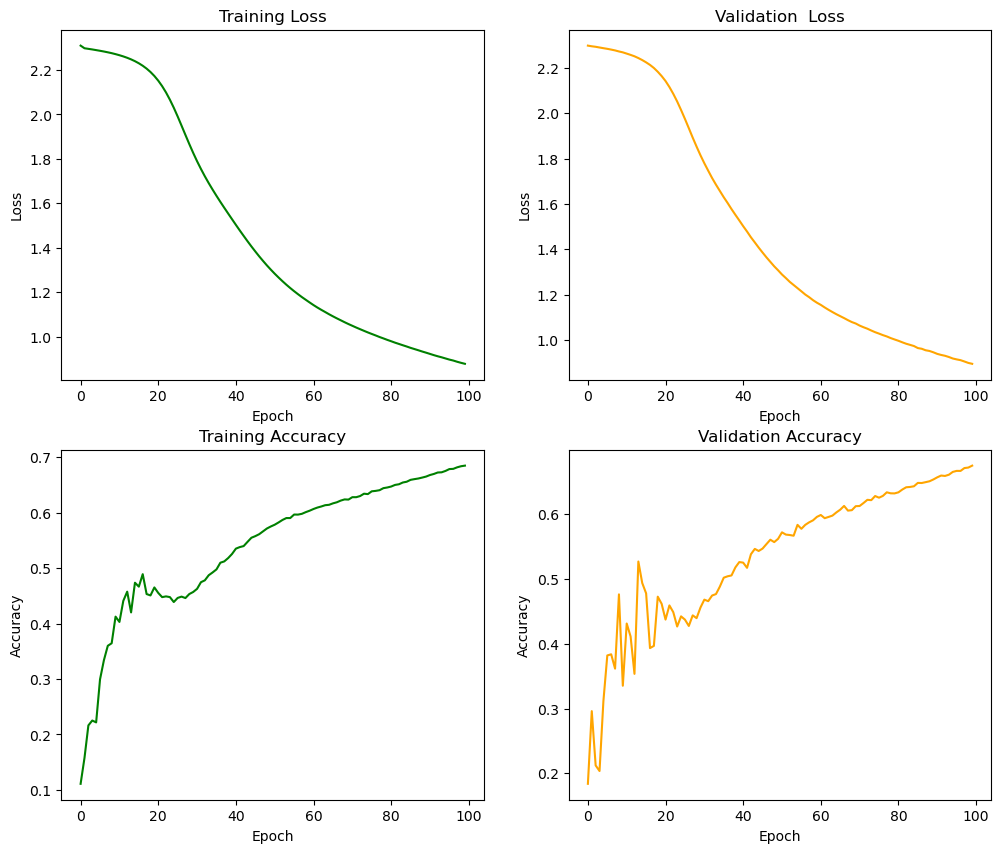

In [51]:
plot(train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst)

In [52]:
test_acc, test_loss = test(model, test_loader, criterion, device)

Evaluation on test set:
Accuracy: 0.6793
Loss: 0.8872


In [53]:
for param in first.parameters():
    param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=100)

Epoch 1/100 - Train loss: 2.3109, Train acc: 0.1100, Validation loss: 2.3031, Validation acc: 0.1100
Epoch 2/100 - Train loss: 2.3025, Train acc: 0.1175, Validation loss: 2.3022, Validation acc: 0.1175
Epoch 3/100 - Train loss: 2.3020, Train acc: 0.1162, Validation loss: 2.3022, Validation acc: 0.1162
Epoch 4/100 - Train loss: 2.3015, Train acc: 0.1264, Validation loss: 2.3016, Validation acc: 0.1264
Epoch 5/100 - Train loss: 2.3010, Train acc: 0.1244, Validation loss: 2.3011, Validation acc: 0.1244
Epoch 6/100 - Train loss: 2.3004, Train acc: 0.1214, Validation loss: 2.3001, Validation acc: 0.1214
Epoch 7/100 - Train loss: 2.3000, Train acc: 0.1258, Validation loss: 2.3002, Validation acc: 0.1258
Epoch 8/100 - Train loss: 2.2994, Train acc: 0.1471, Validation loss: 2.2990, Validation acc: 0.1471
Epoch 9/100 - Train loss: 2.2988, Train acc: 0.1401, Validation loss: 2.2987, Validation acc: 0.1401
Epoch 10/100 - Train loss: 2.2982, Train acc: 0.1633, Validation loss: 2.2988, Validation a

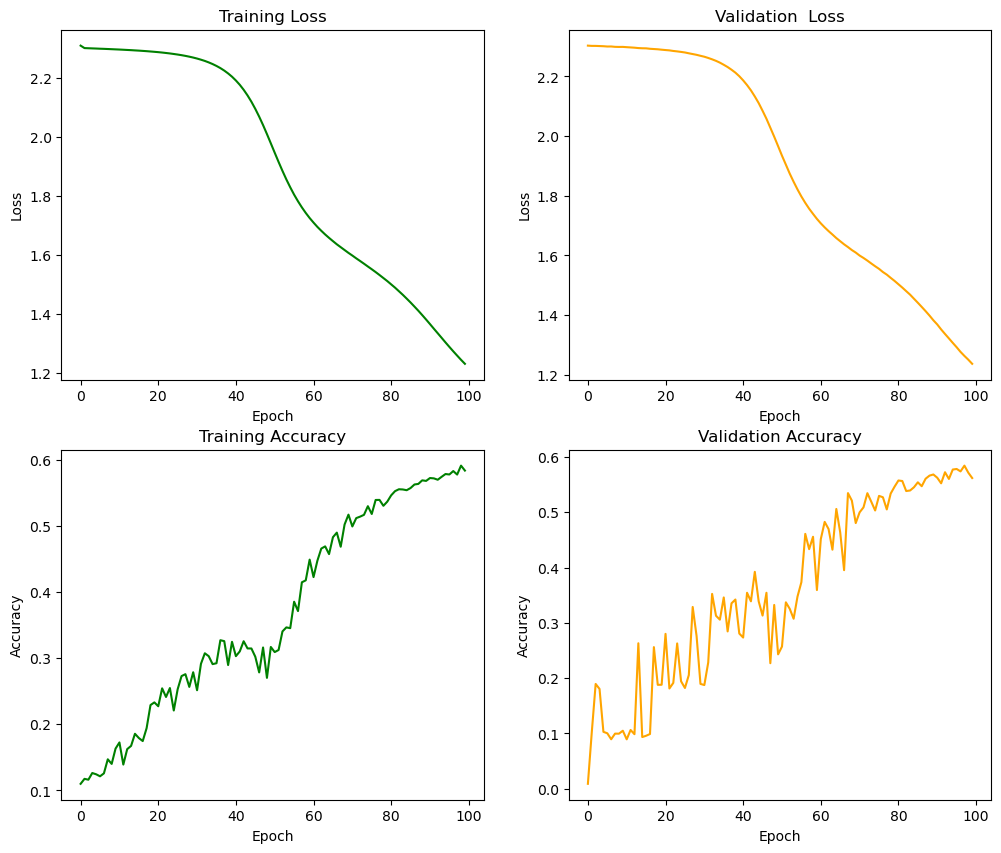

In [54]:
plot(train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst)

In [55]:
test_acc, test_loss = test(model, test_loader, criterion, device)

Evaluation on test set:
Accuracy: 0.5734
Loss: 1.2286


In [56]:
for param in first.parameters():
    param.requires_grad = False

for param in second.parameters():
    param.requires_grad = False
    
model = nn.Sequential(
    first,
    second,
    third,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)
train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=100)

Epoch 1/100 - Train loss: 2.3105, Train acc: 0.1021, Validation loss: 2.3027, Validation acc: 0.1021
Epoch 2/100 - Train loss: 2.3025, Train acc: 0.1019, Validation loss: 2.3026, Validation acc: 0.1019
Epoch 3/100 - Train loss: 2.3021, Train acc: 0.1079, Validation loss: 2.3023, Validation acc: 0.1079
Epoch 4/100 - Train loss: 2.3018, Train acc: 0.1021, Validation loss: 2.3018, Validation acc: 0.1021
Epoch 5/100 - Train loss: 2.3015, Train acc: 0.1083, Validation loss: 2.3016, Validation acc: 0.1083
Epoch 6/100 - Train loss: 2.3013, Train acc: 0.1216, Validation loss: 2.3016, Validation acc: 0.1216
Epoch 7/100 - Train loss: 2.3009, Train acc: 0.1177, Validation loss: 2.3010, Validation acc: 0.1177
Epoch 8/100 - Train loss: 2.3006, Train acc: 0.1212, Validation loss: 2.3006, Validation acc: 0.1212
Epoch 9/100 - Train loss: 2.3003, Train acc: 0.1203, Validation loss: 2.3000, Validation acc: 0.1203
Epoch 10/100 - Train loss: 2.3000, Train acc: 0.1325, Validation loss: 2.2996, Validation a

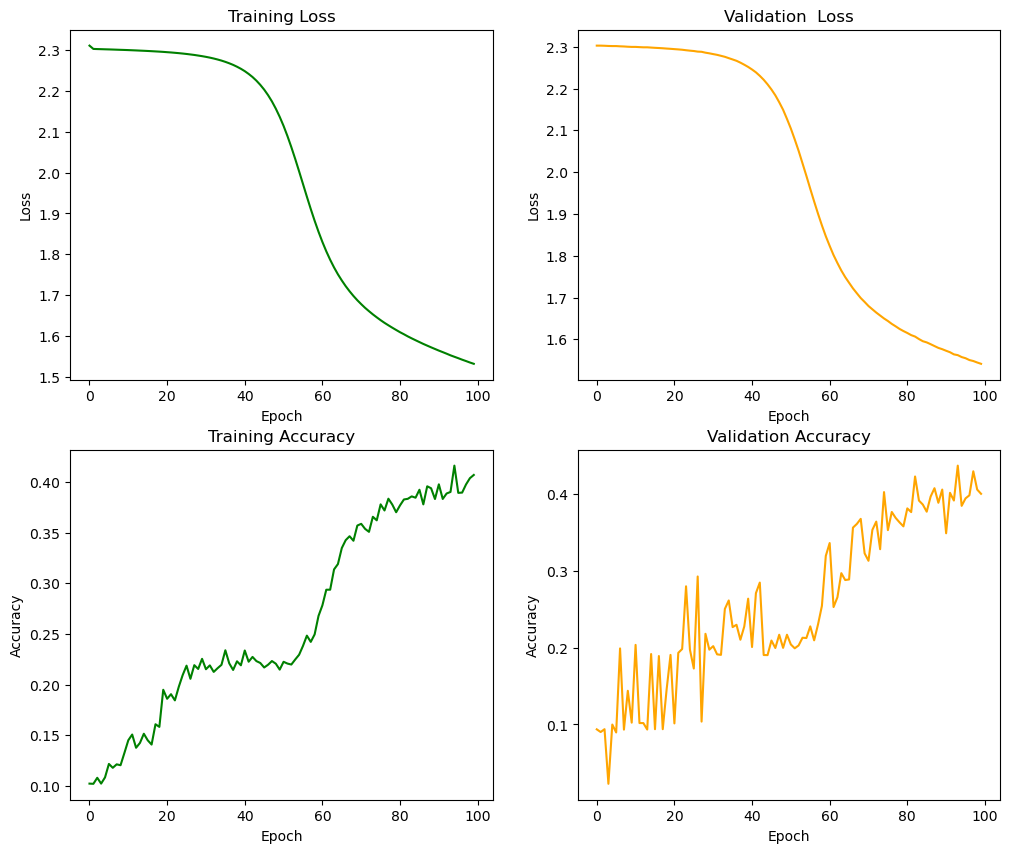

In [57]:
plot(train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst)

In [58]:
test_acc, test_loss = test(model, test_loader, criterion, device)

Evaluation on test set:
Accuracy: 0.4095
Loss: 1.5330


In [59]:
for param in first.parameters():
    param.requires_grad = True  

for param in second.parameters():
    param.requires_grad = True
    
for param in third.parameters():
    param.requires_grad = True
    
model = nn.Sequential(
    first,
    second,
    third,
    fourth,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=100)

Epoch 1/100 - Train loss: 2.3027, Train acc: 0.1107, Validation loss: 2.2938, Validation acc: 0.1107
Epoch 2/100 - Train loss: 2.2893, Train acc: 0.1953, Validation loss: 2.2840, Validation acc: 0.1953
Epoch 3/100 - Train loss: 2.2779, Train acc: 0.1933, Validation loss: 2.2712, Validation acc: 0.1933
Epoch 4/100 - Train loss: 2.2648, Train acc: 0.2066, Validation loss: 2.2580, Validation acc: 0.2066
Epoch 5/100 - Train loss: 2.2491, Train acc: 0.1926, Validation loss: 2.2407, Validation acc: 0.1926
Epoch 6/100 - Train loss: 2.2300, Train acc: 0.2072, Validation loss: 2.2196, Validation acc: 0.2072
Epoch 7/100 - Train loss: 2.2063, Train acc: 0.2017, Validation loss: 2.1935, Validation acc: 0.2017
Epoch 8/100 - Train loss: 2.1773, Train acc: 0.2163, Validation loss: 2.1617, Validation acc: 0.2163
Epoch 9/100 - Train loss: 2.1426, Train acc: 0.2097, Validation loss: 2.1250, Validation acc: 0.2097
Epoch 10/100 - Train loss: 2.1019, Train acc: 0.2237, Validation loss: 2.0814, Validation a

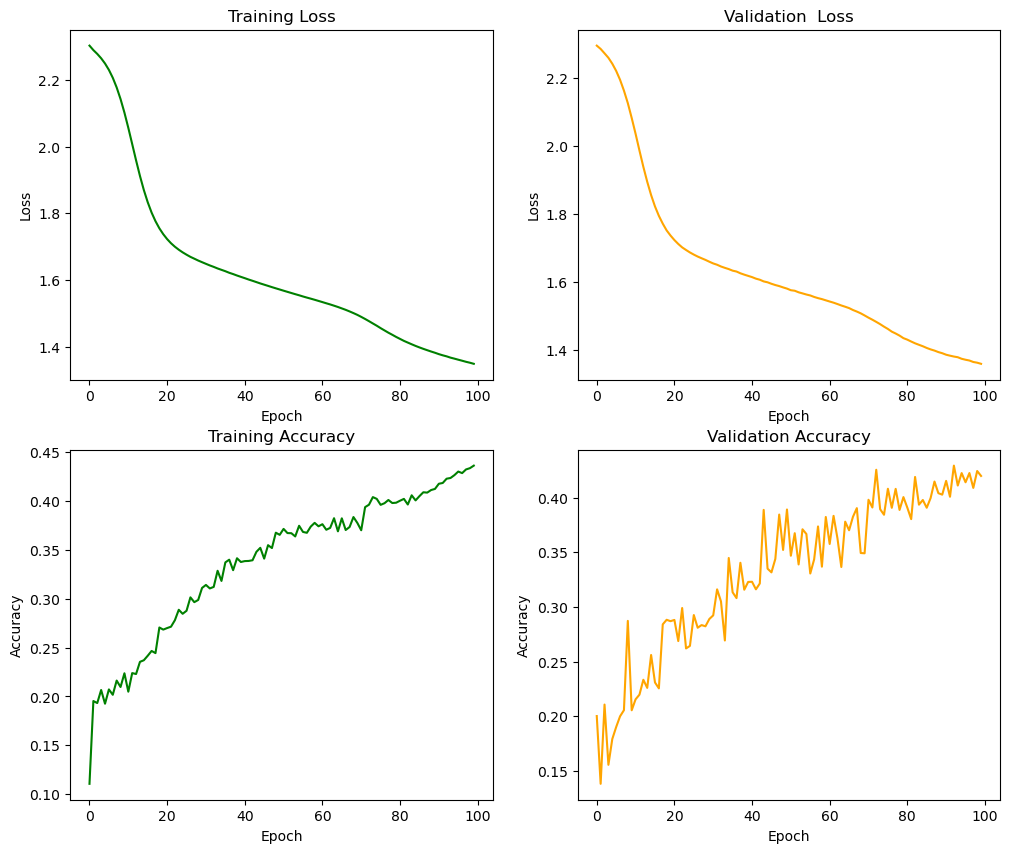

In [60]:
plot(train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst)

In [61]:
test_acc, test_loss = test(model, test_loader, criterion, device)

Evaluation on test set:
Accuracy: 0.4257
Loss: 1.3568


## 7. Gradient Normalization

Là một kỹ thuật với ý tưởng chuẩn hóa gradient trong quá
trình lan truyền ngược. Kỹ thuật này đảm bảo gradient được duy trì trong một phạm vi hợp
lý, tránh việc chúng trở nên quá nhỏ hoặc quá lớn, từ đó giúp cải thiện quá trình học của các
lớp sâu hơn trong mạng. Tại đây, chúng ta cài đặt một lớp GradientNormalizationLayer,
sử dụng cơ chế autograd của PyTorch để chuẩn hóa gradient trong giai đoạn lan truyền
ngược. Cụ thể, gradient được điều chỉnh bằng cách chuẩn hóa theo trung bình và độ lệch
chuẩn của chúng, đảm bảo các giá trị gradient không bị triệt tiêu hoặc phóng đại.

In [ ]:
class GradientNormalization(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input

    @staticmethod
    def backward(ctx, grad_output):
        mean = torch.mean(grad_output)
        std = torch.std(grad_output)
        grad_input = (grad_output - mean) / (std + 1e-6)
        return grad_input

class GradientNormalizationLayer(nn.Module):
    def __init__(self):
        super(GradientNormalizationLayer, self).__init__()
    
    def forward(self, x):
        return GradientNormalization.apply(x)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
    
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = GradientNormalizationLayer()(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = GradientNormalizationLayer()(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = GradientNormalizationLayer()(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = GradientNormalizationLayer()(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = GradientNormalizationLayer()(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = GradientNormalizationLayer()(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = GradientNormalizationLayer()(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)
        return out


input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst = train(model, train_loader, val_loader, criterion, optimizer, device, epochs=100)

Epoch 1/100 - Train loss: 1.9610, Train acc: 0.1805, Validation loss: 2.0830, Validation acc: 0.1805
Epoch 2/100 - Train loss: 1.3125, Train acc: 0.4100, Validation loss: 1.0102, Validation acc: 0.4100
Epoch 3/100 - Train loss: 0.9447, Train acc: 0.5555, Validation loss: 0.8765, Validation acc: 0.5555
Epoch 4/100 - Train loss: 0.8115, Train acc: 0.6363, Validation loss: 0.7680, Validation acc: 0.6363
Epoch 5/100 - Train loss: 0.6686, Train acc: 0.7583, Validation loss: 0.7022, Validation acc: 0.7583
Epoch 6/100 - Train loss: 0.6060, Train acc: 0.7918, Validation loss: 0.6276, Validation acc: 0.7918
Epoch 7/100 - Train loss: 0.5748, Train acc: 0.8004, Validation loss: 0.6183, Validation acc: 0.8004
Epoch 8/100 - Train loss: 0.5748, Train acc: 0.8005, Validation loss: 0.6214, Validation acc: 0.8005
Epoch 9/100 - Train loss: 0.5538, Train acc: 0.8078, Validation loss: 0.5921, Validation acc: 0.8078
Epoch 10/100 - Train loss: 0.5472, Train acc: 0.8111, Validation loss: 0.5771, Validation a

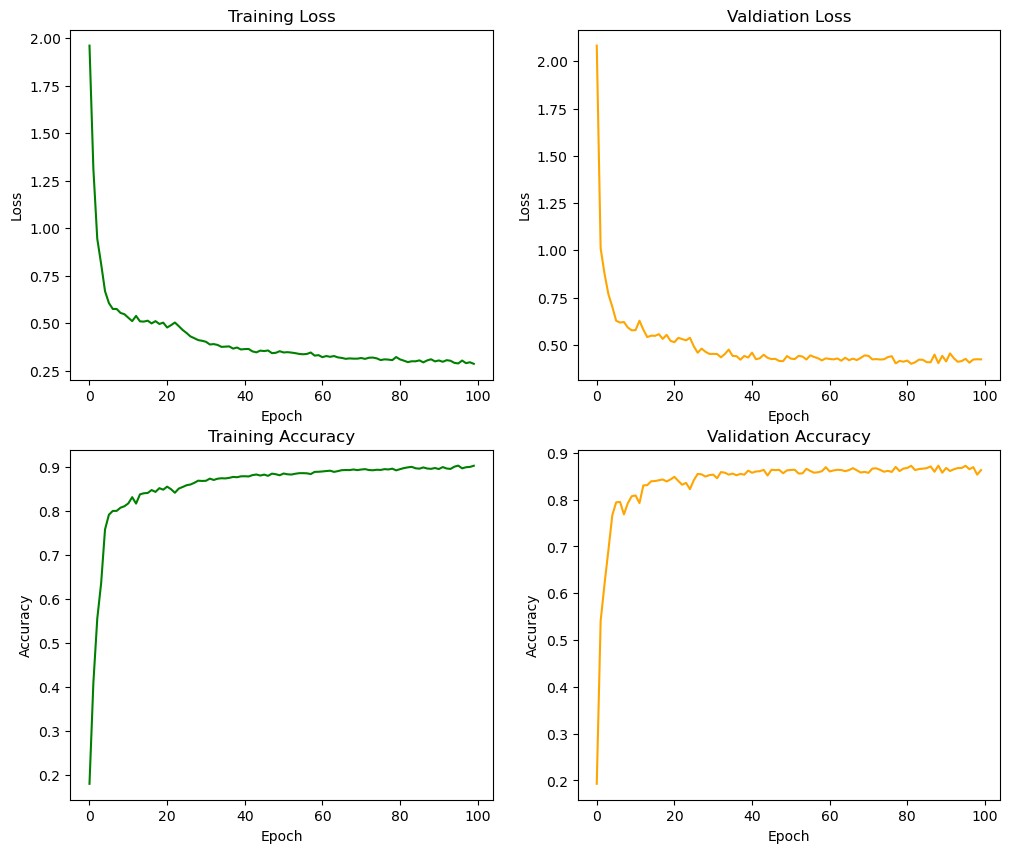

In [ ]:
plot(train_loss_lst, val_loss_lst, train_acc_lst, val_acc_lst)

In [ ]:
test_acc, test_loss = test(model, test_loader, criterion, device)

Evaluation on test set:
Accuracy: 0.8623
Loss: 0.4396
